In [1]:
from google.colab import drive

ROOT = "/content/drive"
print(ROOT)
drive.mount(ROOT)   

/content/drive
Mounted at /content/drive


In [4]:
cd '/content/drive/MyDrive/Colab Notebooks/food_classification'

/content/drive/MyDrive/Colab Notebooks/food_classification


In [5]:
!pip freeze > requirements.txt

In [3]:
pwd

'/content'

In [ ]:
import os
from tqdm import tqdm # 진행률
import xml.etree.ElementTree as ET # XML parser

import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
#@title
ano_dir = '/content/drive/MyDrive/Colab Notebooks/food_classification/음식분류/라벨링데이터/01011001'
img_dir = '/content/drive/MyDrive/Colab Notebooks/food_classification/음식분류/원천데이터'

In [ ]:
#@title
ano_list = os.listdir(ano_dir)
img_list = os.listdir(img_dir)

len(ano_list), len(img_list)

In [ ]:
#@title
ano_new_list = list()
img_new_list = list()

for ano in ano_list:
  ano_new_list.append(ano.split(".")[0])

for img in img_list:
  img_new_list.append(img.split(".")[0])

intersect = list(set(img_new_list) & set(ano_new_list))
intersect.sort()
len(intersect)

In [ ]:
#@title
new_intersect = list(map(lambda x: x+'.jpg', intersect)) + list(map(lambda x: x+'.jpeg', intersect))
new_intersect = list(set(new_intersect) & set(img_list))
new_intersect.sort()
len(new_intersect)

In [ ]:
#@title
df = pd.DataFrame()
for i in tqdm(range(len(intersect))):
  path = '/content/drive/MyDrive/Colab Notebooks/food_classification/음식분류/라벨링데이터/01011001/' + intersect[i] + '.xml'
  tree = ET.parse(path)
  root = tree.getroot()
  obj = root[5][1]
  row = pd.Series([new_intersect[i], int(obj[0].text), int(obj[1].text), int(obj[2].text), int(obj[3].text)])
  df = df.append(row, ignore_index = True)
df.rename(columns = {0 : 'image', 1 : 'xmin', 2 : 'ymin', 3 : 'xmax', 4 : 'ymax'}, inplace = True)

df

In [ ]:
#@title
sample = df.loc[11]

img = cv2.imread(f"{img_dir}/{sample[0]}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (int(sample[1]), int(sample[4]))
pt2 = (int(sample[3]), int(sample[2]))
cv2.rectangle(img, pt1, pt2, color=(255,0,0), thickness=10)
plt.imshow(img)

In [ ]:
#@title
class RiceDataset(Dataset):
    def __init__(self, df, image_dir, transforms=None):
      super().__init__()
      
      self.image_ids = df["image"].unique() # all image filenames
      self.df = df
      self.image_dir = image_dir # dir to image files
      self.transforms = transforms

    def __getitem__(self, idx: int):
      image_id = self.image_ids[idx]
      records = self.df[self.df["image"] == image_id]
      image = cv2.imread(f"{self.image_dir}/{image_id}", cv2.IMREAD_COLOR)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
      image /= 255.0
      image = torch.tensor(image)
      image = image.permute(2,0,1)
      
      
      boxes = records[["xmin", "ymin", "xmax", "ymax"]].values
      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
      area = torch.as_tensor(area, dtype=torch.float32)
      
      # class가 1종류이기 때문에 label은 1로만 지정
      labels = torch.ones((records.shape[0]), dtype=torch.int64)
      
      target = {}
      target["boxes"] = torch.tensor(boxes)
      target["labels"] = labels
      target["image_id"] = torch.tensor([idx])
      target["area"] = area

      if self.transforms:
        sample = {"image": image, "boxes": target["boxes"], "labels": labels}
        sample = self.transforms(**sample)
        image = sample["image"]
        target["boxes"] = torch.stack(tuple(map(torch.tensor, zip(*sample["boxes"])))).permute(1, 0)
      return image, target, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
#@title
def collate_fn(batch):
    return tuple(zip(*batch))

train_ds = RiceDataset(df, img_dir)

train_dl = DataLoader(train_ds, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [ ]:
#@title
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [ ]:
#@title
# Load model pretrained on COCO
model = fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
#@title
num_classes = 2 # 1 class (rice) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace pre-trained head with new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
#@title
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

In [ ]:
#@title
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [ ]:
#@title
num_epochs = 10

for epoch in tqdm(range(num_epochs)):

    model.train()

    for i, (images, targets, image_ids) in enumerate(train_dl):

      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      loss_dict = model(images, targets)
      losses = sum(loss for loss in loss_dict.values())

      optimizer.zero_grad()
      losses.backward()
      optimizer.step()

      if (i+1) % 10 == 0:
        print(f'Epoch {epoch+1} - Total: {losses:.4f}, Regression: {loss_dict["loss_box_reg"]:.4f}, Classifier: {loss_dict["loss_classifier"]:.4f}')

In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/food_classification'

/content/drive/MyDrive/Colab Notebooks/food_classification


In [ ]:
#@title
pwd

In [ ]:
#@title
import os

if not os.path.isdir('new_folder'):
  os.mkdir('./model')

torch.save(model,'./model/model.pt')

In [ ]:
model = torch.load('./model/model.pt')

In [ ]:
sample = '/content/drive/MyDrive/Colab Notebooks/food_classification/1.jpeg'
images = cv2.imread(sample, cv2.IMREAD_COLOR)
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
images /= 255.0

input = torch.tensor(images)
input = input.permute(2,0,1)
input = torch.unsqueeze(input, 0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
input = input.to(device)
model.eval()
cpu_device = torch.device("cpu")

outputs = model(input)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
mask = outputs[0]['scores'] > 0.5
boxes = outputs[0]["boxes"][mask].detach().numpy().astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


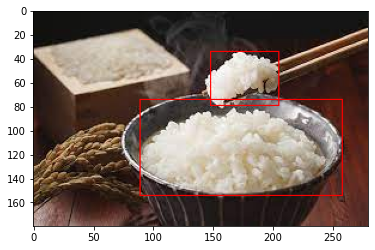

In [ ]:
for box in boxes:
    cv2.rectangle(images,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 1)
    
plt.imshow(images)